# I.  Project Overview

<center><img src="resources/preview.jpg" width="700"></center>

In this project, we'll build a neural network classifier that determines: **MUFFIN... or CHIHUAHUA!**

This is what we'll cover in the tutorial:
#### 1) Build the neural network
#### 2) Load the data
#### 3) Train the model on the data
#### 4) Visualize the results

### Remember: This is an INTERACTIVE Notebook!
You should run and play with the code as you go to see how it works. Select a cell and **press shift-enter to execute code.**

<img src="resources/jupyter_animated.gif" width="700">

# II.  Deep Learning Tutorial

Let's get to the fun stuff!



<center><img src="resources/Pytorch_logo.png" width="700"></center>

**Generic Python imports** (select the below cell and press shift-enter to execute it)

In [1]:
import matplotlib.pyplot as plt  # graphical library, to plot images
# special Jupyter notebook command to show plots inline instead of in a new window
%matplotlib inline

**Deep learning imports**

In [2]:
import torch                                            # PyTorch deep learning framework
from torchvision import datasets, models, transforms    # extension to PyTorch for dataset management
import torch.nn as nn                                   # neural networks module of PyTorch, to let us define neural network layers
from torch.nn import functional as F                    # special functions
import torch.optim as optim                             # optimizers

## (1) Build our Neural Network

Recall from the lesson that a neural network generally looks like this. Input is on the left, output is on the right. The number of output neurons correspond to the number of classes.

<img src="resources/what_is_nn_slide.jpg" width="700">

So let's define a similar architecture for our 2-class muffin-vs-chihuahua classifier:

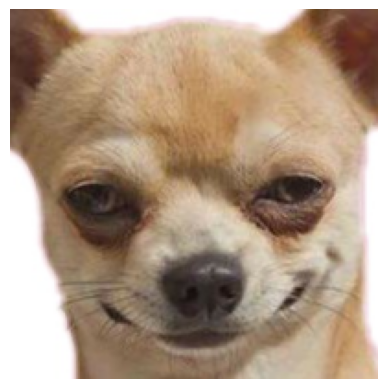

In [3]:
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from PIL import Image

# Define target size for the final output (e.g., 128x128)
target_size = 200

# Custom function to calculate padding
def get_padding(img):
    width, height = img.size
    padding_left = 0
    padding_top = 0
    padding_right = target_size - width if width < target_size else 0
    padding_bottom = target_size - height if height < target_size else 0
    return (padding_left, padding_top, padding_right, padding_bottom)

# Define the transformation pipeline
transform = transforms.Compose([
    transforms.Resize(target_size),  # Resize the smaller dimension to target_size while keeping the aspect ratio
    transforms.Lambda(lambda img: transforms.functional.pad(img, get_padding(img), fill=0)),  # Pad the image to make it square
    transforms.ToTensor()  # Convert the image to a PyTorch tensor
])

# Load the image
img_path = 'data/train/chihuahua/1.jpg'  # Replace with actual path
img = Image.open(img_path)
img_transformed = transform(img)

# Convert tensor to numpy array for display
img_transformed_np = img_transformed.permute(1, 2, 0).numpy()  # Change dimensions to H x W x C

# Display the image using matplotlib
plt.imshow(img_transformed_np)
plt.axis('off')  # Hide axes
plt.show()


input_height = 200
input_width = 200

# Extends PyTorch's neural network baseclass
class MySkynet(nn.Module):
    """
    A very basic neural network.
    """
    def __init__(self, input_dim=(3, input_height, input_width)):
        """
        Constructs a neural network.
        
        input_dim: a tuple that represents "channel x height x width" dimensions of the input
        """
        super().__init__()
        # the total number of RGB pixels in an image is the tensor's volume
        num_in_features = input_dim[0] * input_dim[1] * input_dim[2]
        # input layer
        self.layer_0 = nn.Linear(num_in_features, 128)
        # hidden layers
        self.layer_1 = nn.Linear(128, 64)
        self.layer_2= nn.Linear(64, 32)
        # output layer, output size of 2 for chihuahua and muffin
        self.layer_3= nn.Linear(32, 2)

    def forward(self, x):
        """
        Define the forward pass through our network.
        """
        batch_size = x.shape[0]
        # convert our RGB tensor into one long vector
        x = x.view(batch_size, -1)
        
        # pass through our layers
        x = F.relu(self.layer_0(x))
        x = F.relu(self.layer_1(x))
        x = F.relu(self.layer_2(x))
        x = F.relu(self.layer_3(x))
        
        # convert the raw output to probability predictions
        x = F.softmax(x, dim=1)
        
        return x
    
    

Now that we've defined the network above, let's initialize it. If available, we'll place the network on the GPU; if not, it goes on the CPU.

In [4]:
 # cuda:0 means the first cuda device found
model = MySkynet(input_dim=(3, input_height, input_width))
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
model = model.to(device)                      # load our simple neural network
model

MySkynet(
  (layer_0): Linear(in_features=120000, out_features=128, bias=True)
  (layer_1): Linear(in_features=128, out_features=64, bias=True)
  (layer_2): Linear(in_features=64, out_features=32, bias=True)
  (layer_3): Linear(in_features=32, out_features=2, bias=True)
)

Essentially, our network looks like this:
<img src="resources/architecture.png" width="600">

## (2) Data and Data Loading

### Separate "train" and "test" datasets

Recall from the below slide, we should make two separate datasets to train and test our model. That way, we know our model learns more than rote memorization.

<center><img src="resources/when_is_your_model_ready_slide.jpg" width="600"></center>

### Inspect our data
Let's look in our data folder to see what's there. As you can see, the folder is **split into "train" for training**, and **"validation" for testing** (to validate our model).

In [5]:
import os  # interact with the os. in our case, we want to view the file system

print("Data contents:", os.listdir("data"))
print("Train contents:", os.listdir("data/train"))
print("Validation contents:", os.listdir("data/validation"))

Data contents: ['train', 'validation']
Train contents: ['chihuahua', 'muffin']
Validation contents: ['chihuahua', 'muffin']


Let's also look at some of the images:

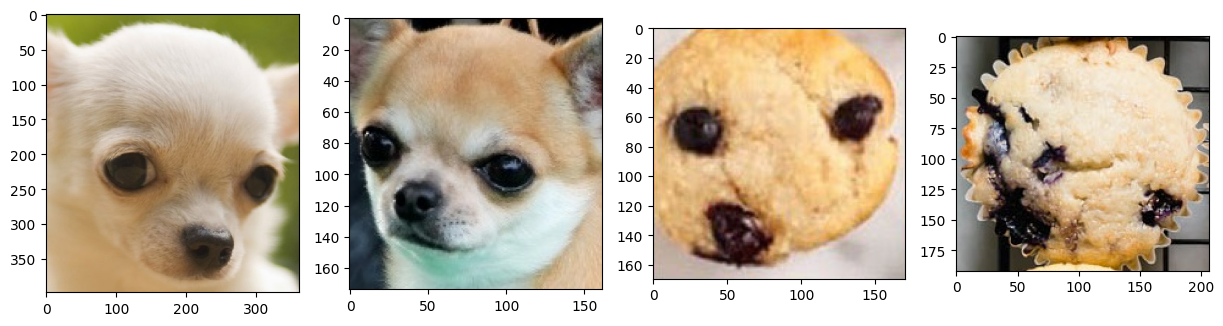

In [6]:
from PIL import Image  # import our image opening tool

_, ax = plt.subplots(1, 4, figsize=(15,60))  # to show 4 images side by side, make a "1 row x 4 column" axes
ax[0].imshow(Image.open("data/train/chihuahua/4.jpg"))  # show the chihuahua in the first column
ax[1].imshow(Image.open("data/train/chihuahua/5.jpg"))  # show the chihuahua in the second column
ax[2].imshow(Image.open("data/train/muffin/131.jpg"))   # show the muffin in the third column
ax[3].imshow(Image.open("data/train/muffin/107.jpg"))   # show the muffin in the fourth column


If you look in the data folder on your computer, there are 120 train images and 30 validation. So our data is split like this:

<img src="resources/folders.png" width="600">

### Load our data

That's great that we have data! But we have to load all the images and convert them into a form that our neural network understands. Specifically, PyTorch works with **Tensor** objects. (A tensor is just a multidimensional matrix, i.e. an N-d array.)

<img src="resources/image_to_tensor.jpg" width="550">


**To easily convert our image data into tensors, we use the help of a "dataloader."** The dataloader packages data into convenient boxes for our model to use. You can think of it like one person passing boxes (tensors) to another.
<img src="resources/dataloader_box_analogy.jpg" width="400">

**First, we define some "transforms" to convert images to tensors.** We must do so for both our train and validation datasets.

For more information about transforms, check out the link here: https://pytorch.org/docs/stable/torchvision/transforms.html

In [7]:
normalize = transforms.Normalize(mean=[0.5, 0.5, 0.5],
                                 std=[0.5, 0.5, 0.5])

# transforms for our training data
train_transforms = transforms.Compose([
    # resize to resnet input size
    transforms.Resize((input_height,input_width)),
    # transform image to PyTorch tensor object
    transforms.ToTensor(),
    normalize
])

# these validation transforms are exactly the same as our train transforms
validation_transforms = transforms.Compose([
    transforms.Resize((input_height,input_width)),
    transforms.ToTensor(),
    normalize
])

print("Train transforms:", train_transforms)

Train transforms: Compose(
    Resize(size=(200, 200), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
    Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
)


**Second, we create the datasets, by passing the transforms into the ImageFolder constructor.**

These just represent the folders that hold the images.

In [8]:
# insert respective transforms to replace ?
image_datasets = {
    'train':
        datasets.ImageFolder('data/train', transform=train_transforms),
    'validation':
        datasets.ImageFolder('data/validation', transform=validation_transforms)}


print("==Train Dataset==\n", image_datasets["train"])
print()
print("==Validation Dataset==\n", image_datasets["train"])

==Train Dataset==
 Dataset ImageFolder
    Number of datapoints: 125
    Root location: data/train
    StandardTransform
Transform: Compose(
               Resize(size=(200, 200), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
           )

==Validation Dataset==
 Dataset ImageFolder
    Number of datapoints: 125
    Root location: data/train
    StandardTransform
Transform: Compose(
               Resize(size=(200, 200), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
               Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
           )


**And finally, form dataloaders from the datasets:**

In [9]:
# define batch size, number of images to load in at once

dataloaders = {
    'train':
        torch.utils.data.DataLoader(
            image_datasets['train'],
            batch_size=64, #selected 64 for the balance between the speed and memory usage.
            shuffle=True,
            num_workers=4),
    'validation':
        torch.utils.data.DataLoader(
            image_datasets['validation'],
            batch_size=64, #selected 64 for the balance between the speed and memory usage.
            shuffle=False,
            num_workers=4)}

print("Train loader:", dataloaders["train"])
print("Validation loader:", dataloaders["validation"])

Train loader: <torch.utils.data.dataloader.DataLoader object at 0x7fdd6a655580>
Validation loader: <torch.utils.data.dataloader.DataLoader object at 0x7fdd6a655760>


We can see a dataloader outputs 2 things: a BIG tensor to represent an image, and a vector to represent the labels (0 or 1).

In [10]:
next(iter(dataloaders["train"]))

[tensor([[[[ 0.9765,  0.9765,  0.9765,  ...,  0.9843,  0.9843,  0.9765],
           [ 0.9765,  0.9765,  0.9765,  ...,  0.9843,  0.9843,  0.9765],
           [ 0.9765,  0.9843,  0.9843,  ...,  0.9843,  0.9843,  0.9843],
           ...,
           [ 0.9451,  0.9451,  0.9373,  ...,  0.5686,  0.5765,  0.5843],
           [ 0.9451,  0.9451,  0.9451,  ...,  0.5843,  0.5922,  0.6000],
           [ 0.9451,  0.9451,  0.9451,  ...,  0.5922,  0.6000,  0.6078]],
 
          [[ 0.9529,  0.9529,  0.9529,  ...,  0.9608,  0.9608,  0.9529],
           [ 0.9529,  0.9529,  0.9529,  ...,  0.9608,  0.9608,  0.9529],
           [ 0.9529,  0.9608,  0.9608,  ...,  0.9608,  0.9608,  0.9608],
           ...,
           [ 0.9137,  0.9137,  0.9059,  ...,  0.4745,  0.4824,  0.4902],
           [ 0.9137,  0.9137,  0.9137,  ...,  0.4902,  0.4980,  0.5059],
           [ 0.9137,  0.9137,  0.9137,  ...,  0.4980,  0.5059,  0.5137]],
 
          [[ 0.9137,  0.9137,  0.9137,  ...,  0.9216,  0.9216,  0.9137],
           [ 

## (4) Train the model!

Hurray! We've built a neural network and have data to give it. Now we **repeatedly iterate over the data to train the model.**

Every time the network gets a new example, it looks something like this. Note the **forward pass** and the corresponding **backward pass**.

<img src="resources/backpropagation.gif" width="700">

### Define the train loop

We want the network to learn from every example in our training dataset. However, the best performance comes from more practice. Therefore, we **run through our dataset for multiple *epochs*.**

After each epoch, we'll check how our model performs on the validation set to monitor its progress.

In [11]:
from tqdm.notebook import tqdm, trange  # Add this line to resolve the NameError

def train_model(model, dataloaders, loss_function, optimizer, num_epochs):
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)  # Learning rate scheduler

    for epoch in trange(num_epochs, desc="Total progress", unit="epoch"):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('----------------')

        for phase in ['train', 'validation']:
            if phase == 'train':
                model.train()
            else:
                model.eval() 

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in tqdm(dataloaders[phase], desc=phase, unit="batch", leave=False):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # FORWARD PASS
                outputs = model(inputs)
                loss = loss_function(outputs, labels)

                if phase == 'train':
                    optimizer.zero_grad()  
                    loss.backward()  
                    optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(image_datasets[phase])
            epoch_acc = running_corrects.double() / len(image_datasets[phase])
            print(f'{phase} error: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}')
        
        scheduler.step()  # Update the learning rate after each epoch
        print()

### Loss function and optimizer

One last thing: we must define a function that gives feedback for how well the model performs. This is the **loss**, or "error" **function**, that compares model predictions to the true labels.

Once we calculate the error, we also need to define how the model should react to that feedback. **The optimizer determines how the network learns from feedback.**

In [12]:
loss_function = nn.CrossEntropyLoss()              # the most common error function in deep learning
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

<img src="resources/gradient_descent.gif" width="700">

### Run training

Let's put everything together and TRAIN OUR MODEL! =D

In [13]:
train_model(model, dataloaders, loss_function, optimizer, num_epochs=15)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

def initialize_weights(model):
    for m in model.modules():
        if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
            nn.init.xavier_uniform_(m.weight)
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)

model = MySkynet()
initialize_weights(model)



Total progress:   0%|          | 0/15 [00:00<?, ?epoch/s]

Epoch 1/15
----------------


train:   0%|          | 0/2 [00:00<?, ?batch/s]

train error: 0.6274, Accuracy: 0.6400


validation:   0%|          | 0/1 [00:00<?, ?batch/s]

validation error: 0.4858, Accuracy: 0.8333

Epoch 2/15
----------------


train:   0%|          | 0/2 [00:00<?, ?batch/s]

train error: 0.4143, Accuracy: 0.8960


validation:   0%|          | 0/1 [00:00<?, ?batch/s]

validation error: 0.4258, Accuracy: 0.9000

Epoch 3/15
----------------


train:   0%|          | 0/2 [00:00<?, ?batch/s]

train error: 0.3814, Accuracy: 0.9360


validation:   0%|          | 0/1 [00:00<?, ?batch/s]

validation error: 0.3962, Accuracy: 0.9000

Epoch 4/15
----------------


train:   0%|          | 0/2 [00:00<?, ?batch/s]

train error: 0.3661, Accuracy: 0.9520


validation:   0%|          | 0/1 [00:00<?, ?batch/s]

validation error: 0.3807, Accuracy: 0.9333

Epoch 5/15
----------------


train:   0%|          | 0/2 [00:00<?, ?batch/s]

train error: 0.3644, Accuracy: 0.9520


validation:   0%|          | 0/1 [00:00<?, ?batch/s]

validation error: 0.3865, Accuracy: 0.9333

Epoch 6/15
----------------


train:   0%|          | 0/2 [00:00<?, ?batch/s]

train error: 0.3644, Accuracy: 0.9520


validation:   0%|          | 0/1 [00:00<?, ?batch/s]

validation error: 0.4086, Accuracy: 0.9000

Epoch 7/15
----------------


train:   0%|          | 0/2 [00:00<?, ?batch/s]

train error: 0.3653, Accuracy: 0.9440


validation:   0%|          | 0/1 [00:00<?, ?batch/s]

validation error: 0.4138, Accuracy: 0.9000

Epoch 8/15
----------------


train:   0%|          | 0/2 [00:00<?, ?batch/s]

train error: 0.3639, Accuracy: 0.9520


validation:   0%|          | 0/1 [00:00<?, ?batch/s]

validation error: 0.4139, Accuracy: 0.9000

Epoch 9/15
----------------


train:   0%|          | 0/2 [00:00<?, ?batch/s]

train error: 0.3634, Accuracy: 0.9520


validation:   0%|          | 0/1 [00:00<?, ?batch/s]

validation error: 0.4136, Accuracy: 0.9000

Epoch 10/15
----------------


train:   0%|          | 0/2 [00:00<?, ?batch/s]

train error: 0.3586, Accuracy: 0.9600


validation:   0%|          | 0/1 [00:00<?, ?batch/s]

validation error: 0.4134, Accuracy: 0.9000

Epoch 11/15
----------------


train:   0%|          | 0/2 [00:00<?, ?batch/s]

train error: 0.3573, Accuracy: 0.9600


validation:   0%|          | 0/1 [00:00<?, ?batch/s]

validation error: 0.4135, Accuracy: 0.9000

Epoch 12/15
----------------


train:   0%|          | 0/2 [00:00<?, ?batch/s]

train error: 0.3573, Accuracy: 0.9600


validation:   0%|          | 0/1 [00:00<?, ?batch/s]

validation error: 0.4138, Accuracy: 0.9000

Epoch 13/15
----------------


train:   0%|          | 0/2 [00:00<?, ?batch/s]

train error: 0.3569, Accuracy: 0.9600


validation:   0%|          | 0/1 [00:00<?, ?batch/s]

validation error: 0.4140, Accuracy: 0.9000

Epoch 14/15
----------------


train:   0%|          | 0/2 [00:00<?, ?batch/s]

train error: 0.3567, Accuracy: 0.9600


validation:   0%|          | 0/1 [00:00<?, ?batch/s]

validation error: 0.4142, Accuracy: 0.9000

Epoch 15/15
----------------


train:   0%|          | 0/2 [00:00<?, ?batch/s]

train error: 0.3565, Accuracy: 0.9600


validation:   0%|          | 0/1 [00:00<?, ?batch/s]

validation error: 0.4142, Accuracy: 0.9000



## Examine model performance

<img src="resources/question_mark.jpg" width="200" >

**How do we examine our model's predictions? Let's visualize what the model thinks on the validation set.**

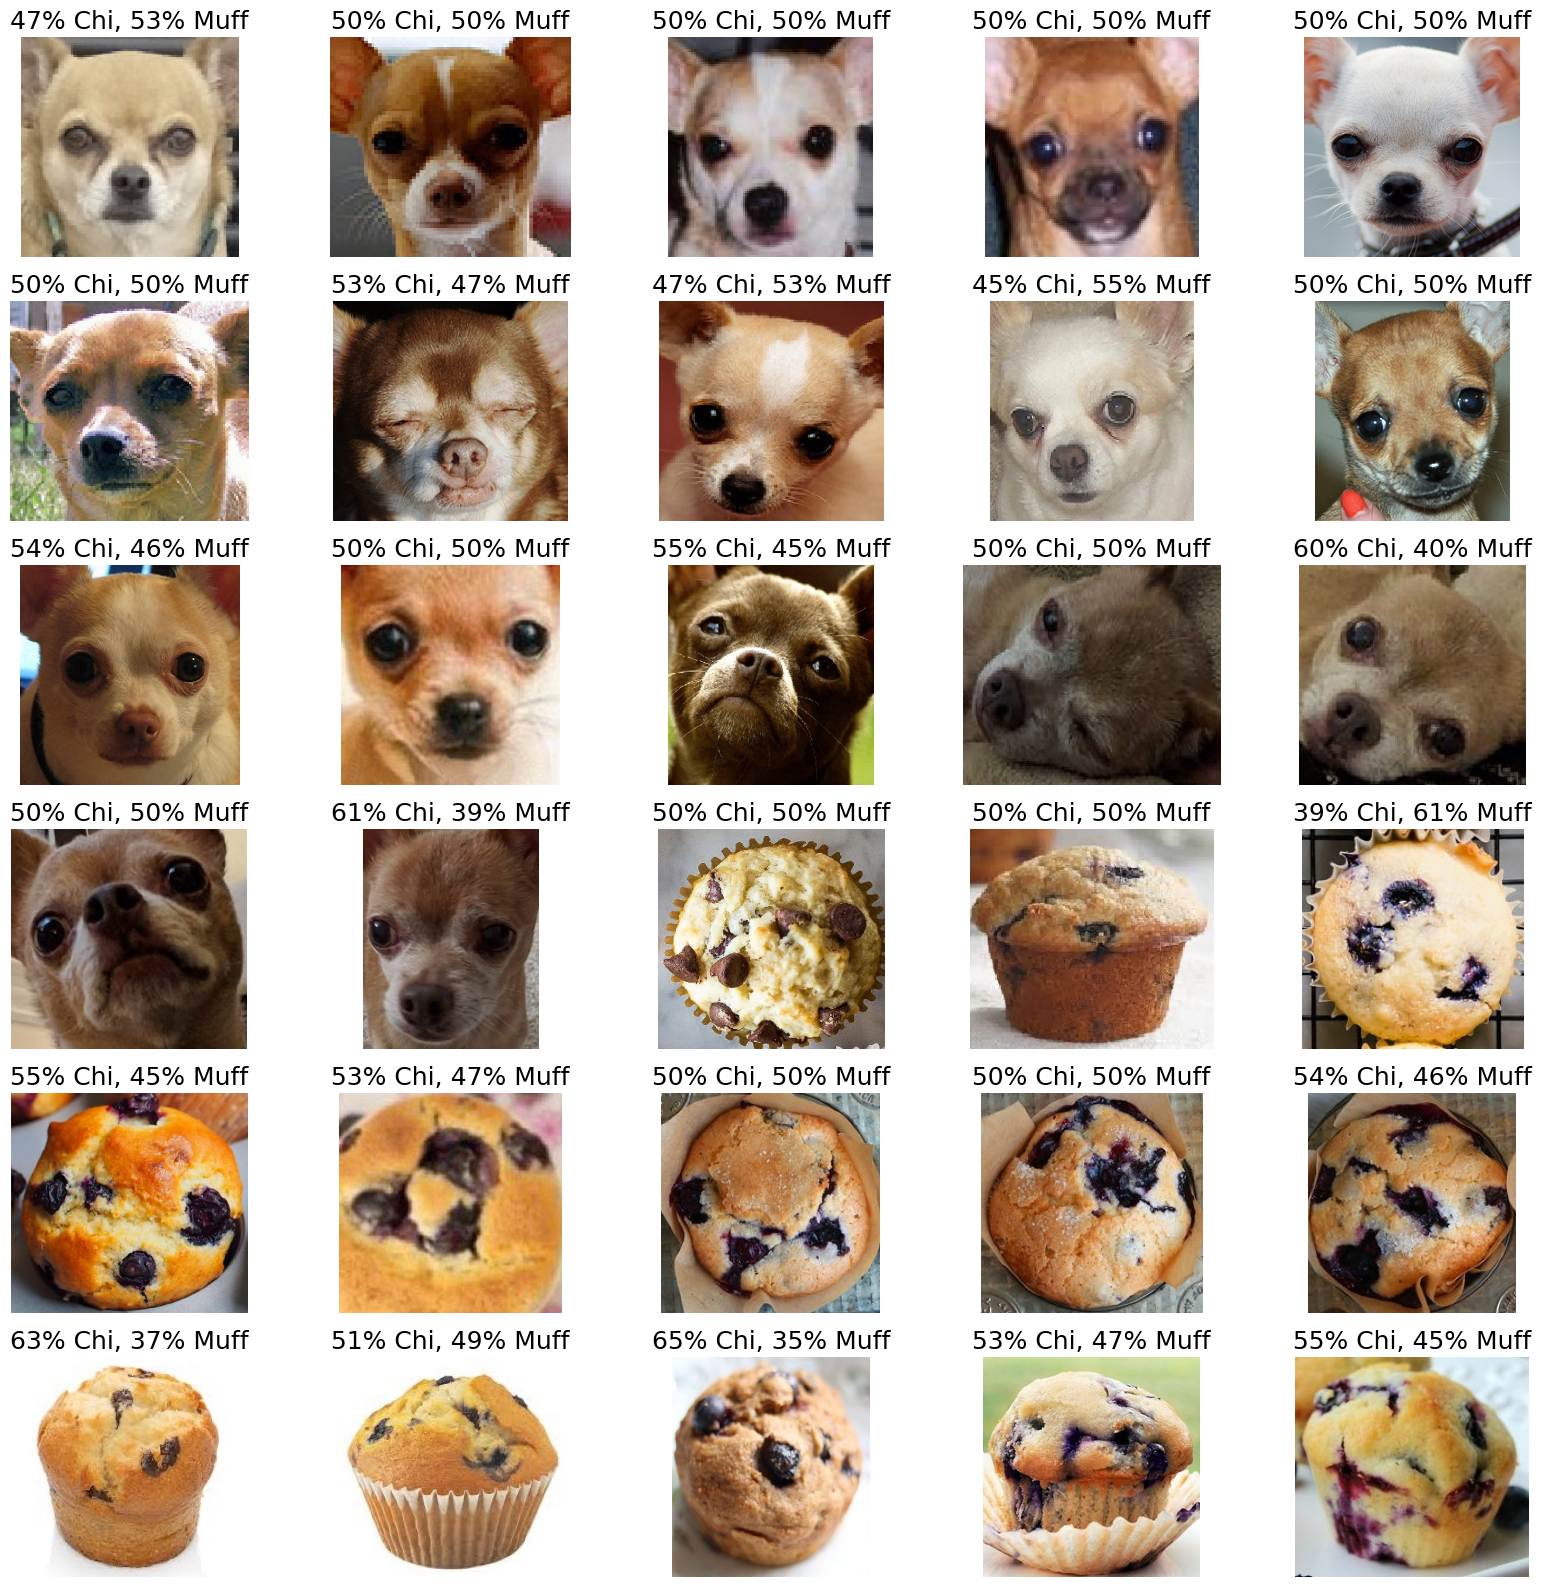

In [14]:
from glob import glob
from math import floor

# get all the images from our validation sets
validation_img_paths = glob("data/validation/**/*.jpg", recursive=True)
images = [Image.open(img_path) for img_path in validation_img_paths]

# put all the images together to run through our model
validation_batch = torch.stack( [validation_transforms(img).to(device) for img in images])
pred_logits_tensor = model(validation_batch)
pred_probs = pred_logits_tensor.cpu().data.numpy()

# show the probabilities for each picture
fig, axs = plt.subplots(6, 5, figsize=(20, 20))
for i, img in enumerate(images):
    ax = axs[floor(i/5)][i % 5]
    ax.axis('off')
    ax.set_title("{:.0f}% Chi, {:.0f}% Muff".format(100*pred_probs[i,0], 100*pred_probs[i,1]), fontsize=18)
    ax.imshow(img)

**Consider:** How accurate was your model? How confident were its predictions? Does it make clear-cut decisions?

## Congratulations! You've successfully trained a neural network!

In [15]:
images, labels = next(iter(dataloaders['train']))
print(labels)  # Checking that the labels are a mix of 0s and 1s so that images are not assigned to same label.

tensor([0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1,
        0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0,
        1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1])


# III.  Can You Do Better?

Now that we've shown you how to train a neural network, can you improve the validation accuracy by tweaking the parameters? **We challenge you to reach 100% accuracy!**

Some parameters to play with:
- Number of epochs
- The learning rate "lr" parameter in the optimizer
- The type of optimizer (https://pytorch.org/docs/stable/optim.html)
- Number of layers and layer dimensions
- Image size
- Data augmentation transforms (https://pytorch.org/docs/stable/torchvision/transforms.html)

# Special Thanks!

Credit for the original idea and code goes to [DeepSense.ai](https://deepsense.ai/keras-vs-pytorch-avp-transfer-learning/)!
We've modified it significantly to cater to this workshop, and boost the visual appeal.

This tutorial was created through hard work and love by Jing Zhao, Dylan Wang, Jason Do, Jason Jiang, and Andrew Jong.